<span style="font-family:Times; font-size:2em;">
Importing Libraries:

pandas: DataFrame, basic stats

matplotlib: plotting

numpy: Arrays and math functions

sklearn: Machine Learning, data preparation
</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import  RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000



<span style="font-family:Times; font-size:2em;">
Reading data output from maindriver_newton.C.
Removes the header.
Converts all columns from string to the correct datatype.
Creates the Label column.
Splits data into a train sample and a test sample.
Drops constituents below subleading particle for robustness.
X_tru = p_T^{pythia}/N_Trk
</span>

In [2]:
def get_data(filename, names_=['p_T', 'Eta', 'Phi', 'Area', 'Rho', 'p_T-corr', 'N-Trk', 'Angularity', 'Angularity-NW', 'Mean-p_T', 'p_T_1', 'p_T_2', 'p_T_3', 'p_T_4', 'p_T_5','distmatch','XMatch', 'X_tru']):
       '''
       Takes a filename and the names of the columns in the CSV file. Returns a DataFrame.
       '''
       dat = pd.read_csv(filename, names=names_)
       dat = dat[dat.p_T!='p_T']
       return dat

def add_feats(dat):
       dat_copy = dat.copy()
       dat_copy["pythia-mom"] = dat_copy['X_tru']*dat_copy['N-Trk']
       return dat_copy

def label_data(dat, label_metric = 'pythia-mom',label_bins=[-1,0.00000001 ,10,10000000], labels_=[1,2,3]):
       dat['Label'] = pd.cut(dat[label_metric], bins=label_bins, labels=labels_)
       
       dat['Label']=dat['Label'].astype(np.int64)
       
       return dat

def type_data(dat):
       dat_typed = dat.astype({'p_T': np.float64, 'Eta': np.float64, 'Phi': np.float64, 'Area': np.float64, 'Rho':np.float64, 'p_T-corr': np.float64, 'N-Trk': np.int64, 'Angularity': np.float64, 'Angularity-NW':np.float64, 'Mean-p_T': np.float64, 'p_T_1': np.float64, 'p_T_2': np.float64, 'p_T_3': np.float64, 'p_T_4': np.float64, 'p_T_5': np.float64, 'distmatch':np.float64, 'XMatch':np.float64, 'X_tru': np.float64})
       return dat_typed
       
def split_data(dat):
       train, test = train_test_split(dat, test_size=0.2, random_state=42)
       return train, test

def drop_feat(dat, feat=['p_T_3', 'p_T_4', 'p_T_5']):
       dat_drop = dat.drop(feat, 1)
       return dat_drop

dat = get_data("../Generator Output/merged_ML_output_LOW_STATS3.csv")
dat_typed = type_data(dat)
dat_feat_added = add_feats(dat_typed)
dat_labeled = label_data(dat_feat_added, 'pythia-mom', [-1,0.000000001, 10, 10000000], [0,1,2])
dat_drop = drop_feat(dat_labeled, ['Eta', 'Phi', 'p_T', 'Angularity-NW', 'N-Trk', 'p_T_2', 'p_T_3', 'p_T_4', 'p_T_5', 'distmatch', 'XMatch'])
train, test = split_data(dat_drop)



<span style="font-family:Papyrus; font-size:2em;">
Adds a column to train, "X_tru_sum", that represents the total momentum fraction from pythia in the FastJet jet. Plots a histogram of this variable.
</span>

In [3]:
print("Number of Features:",len(train.columns))
print("Number of Fake Jets:", len(train.loc[train['Label']==0]))
print("Number of Squishy Jets:", len(train.loc[train['Label']==1]))
print("Number of Real Jets:", len(train.loc[train['Label']==2]))
train.describe()

Number of Features: 9
Number of Fake Jets: 189909
Number of Squishy Jets: 421941
Number of Real Jets: 55914


,Area,Rho,p_T-corr,Angularity,Mean-p_T,p_T_1,X_tru,pythia-mom,Label
count,667764.000000,667764.000000,667764.000000,667764.000000,667764.000000,667764.000000,667764.000000,667764.000000,667764.000000
mean,0.326149,217.549766,-29.235561,0.235939,0.536556,3.019927,0.019048,3.095455,0.799338
std,0.147816,34.541240,37.064937,0.038137,0.063181,2.320544,0.037757,7.540393,0.572594
min,0.014033,46.952200,-116.375000,0.034370,0.265667,0.676535,0.000000,0.000000,0.000000
25%,0.200469,195.679750,-60.393275,0.222330,0.496886,2.088150,0.000000,0.000000,0.000000
50%,0.343804,215.891000,-28.102800,0.248574,0.533478,2.537885,0.005308,0.652837,1.000000
75%,0.479120,237.091000,0.585980,0.261647,0.571940,3.112650,0.020395,2.584086,1.000000
max,0.692619,994.208000,396.925000,0.443650,2.042090,78.941800,1.564460,381.728240,2.000000


[]

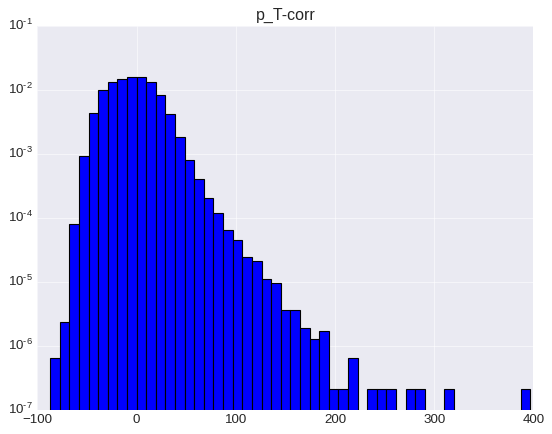

In [20]:
dat_typed.loc[dat_typed['Area']>0.6*3.1415*0.4**2].hist('p_T-corr', bins=50, density=True)
plt.semilogy()

<span style="font-family:Papyrus; font-size:2em;">
Making Dataframes X, Y that will become the inputs to the machine learning. We drop "N-Trk", "X_tru", "X_tru_sum", "Label" for robustness in the case of "N-Trk" and to hide the labels from our algorithm. X is the feature set and Y is the Label set. 
</span>

In [4]:
def split_feat_label(data, drop_labels=['X_tru', 'pythia-mom', 'Label'], label_='Label'):
    X = data.drop(drop_labels, 1)
    Y=data[label_]
    return X, Y

X, Y = split_feat_label(train)

<span style="font-family:Papyrus; font-size:2em;">
Plotting the "Mean-p_T for the Fake and 10% True jets."
</span>

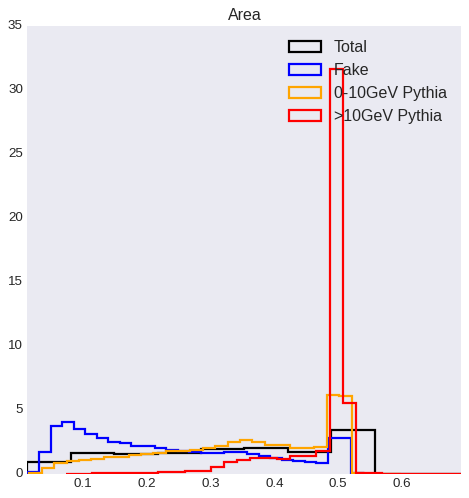

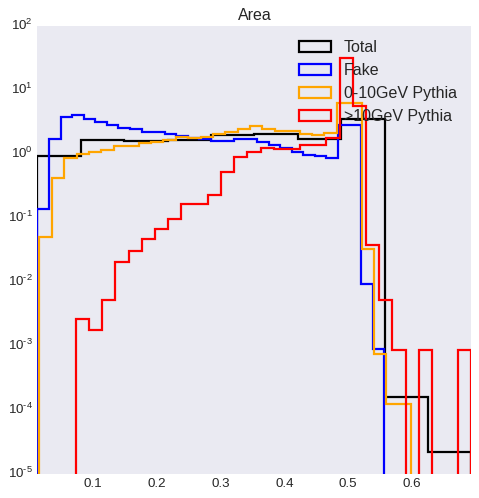

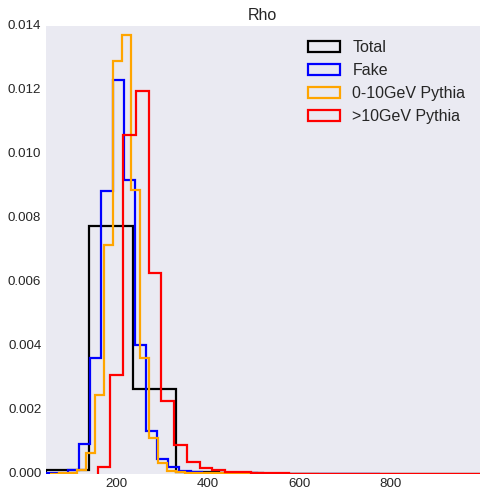

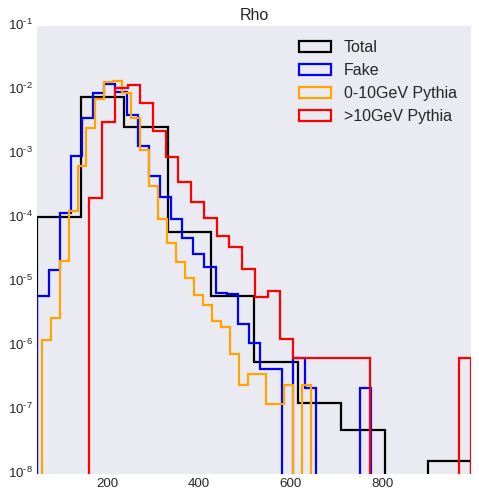

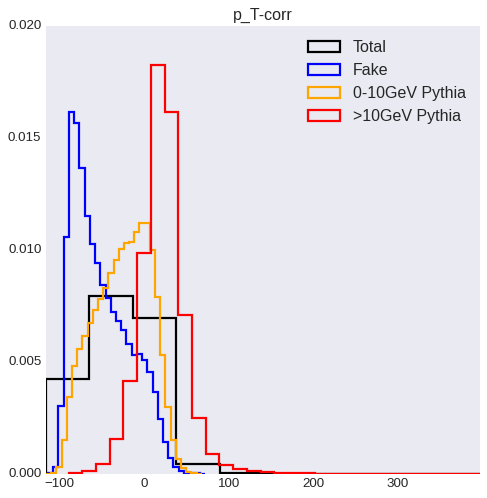

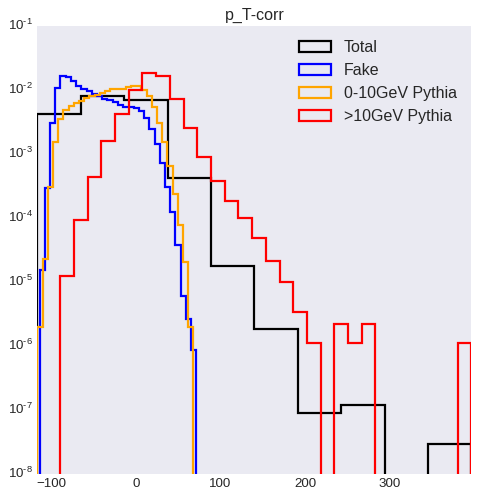

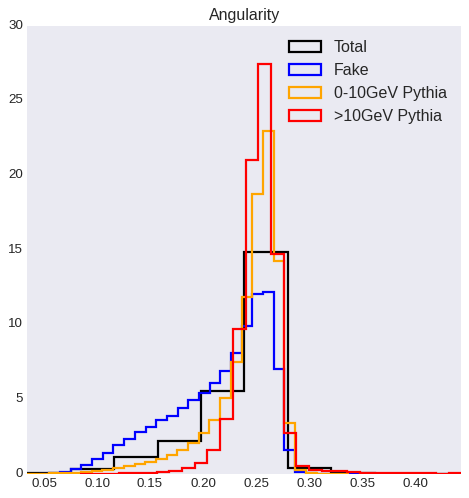

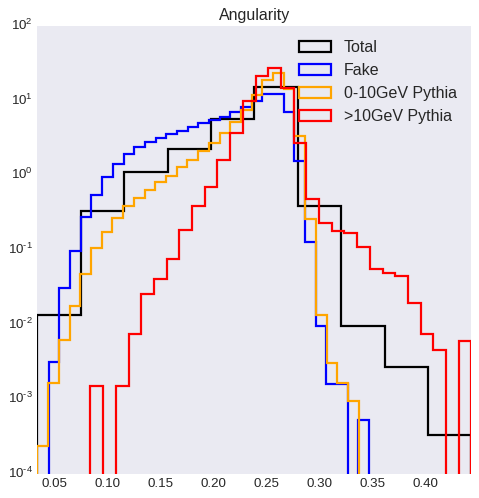

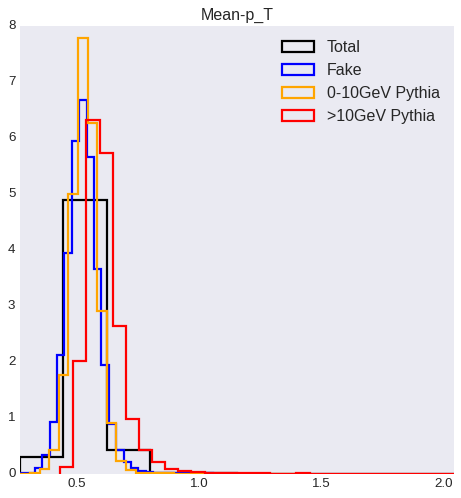

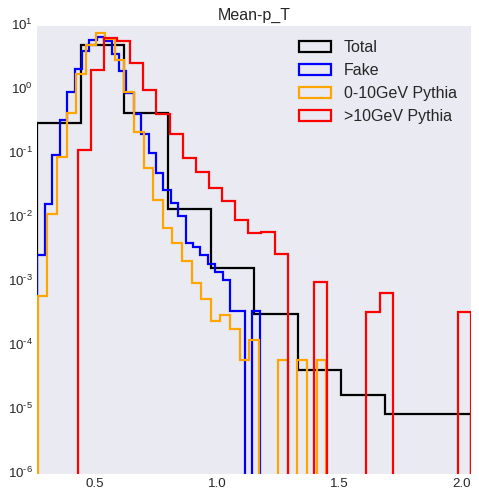

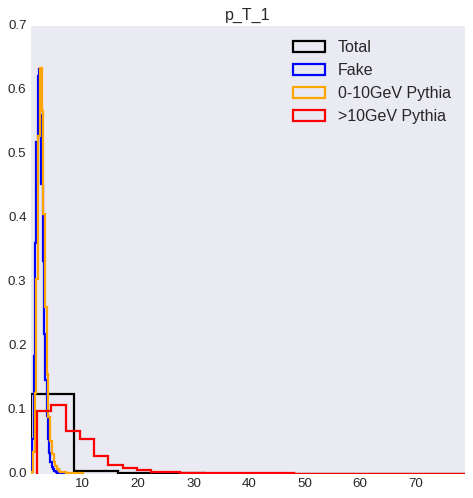

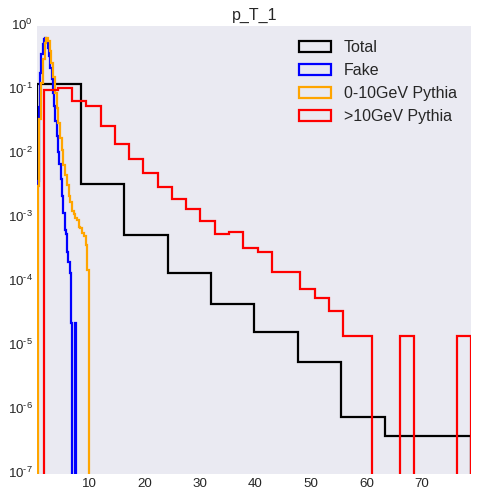

In [13]:
def plot_population(feat):
    fig = plt.figure(figsize=(7,7))
    minx = train[feat].min()
    maxx = train[feat].max()
    train.hist(feat, density=True,ax=plt.gca(), label="Total",histtype=u'step', linewidth=2, color='black')
    train.loc[train['Label']==0].hist(feat,bins=30, density=True,ax=plt.gca(), label="Fake",histtype=u'step', linewidth=2, color='blue')
    train.loc[train['Label']==1].hist(feat,bins=30, density=True,ax=plt.gca(), label="0-10GeV Pythia",histtype=u'step', linewidth=2, color='orange')
    train.loc[train['Label']==2].hist(feat,bins=30, density=True,ax=plt.gca(), label=">10GeV Pythia",histtype=u'step', linewidth=2, color='red')
    plt.xlim(minx, maxx)
    plt.legend(loc='best')
    plt.grid(0)
    #plt.semilogy()

def plot_population_log(feat):
    fig = plt.figure(figsize=(7,7))
    minx = train[feat].min()
    maxx = train[feat].max()
    train.hist(feat, density=True,ax=plt.gca(), label="Total",histtype=u'step', linewidth=2, color='black')
    train.loc[train['Label']==0].hist(feat,bins=30, density=True,ax=plt.gca(), label="Fake",histtype=u'step', linewidth=2, color='blue')
    train.loc[train['Label']==1].hist(feat,bins=30, density=True,ax=plt.gca(), label="0-10GeV Pythia",histtype=u'step', linewidth=2, color='orange')
    train.loc[train['Label']==2].hist(feat,bins=30, density=True,ax=plt.gca(), label=">10GeV Pythia",histtype=u'step', linewidth=2, color='red')
    plt.xlim(minx, maxx)
    plt.legend(loc='best')
    plt.grid(0)
    plt.semilogy()

plt.style.use("seaborn-dark")
for cols in X.columns:
    plot_population(cols)
    plot_population_log(cols)

<span style="font-family:Papyrus; font-size:2em;">
Plotting the correlations between variables. I-Spy: Look for variables that are not that correlated with other variables(weakly correlated).
</span>

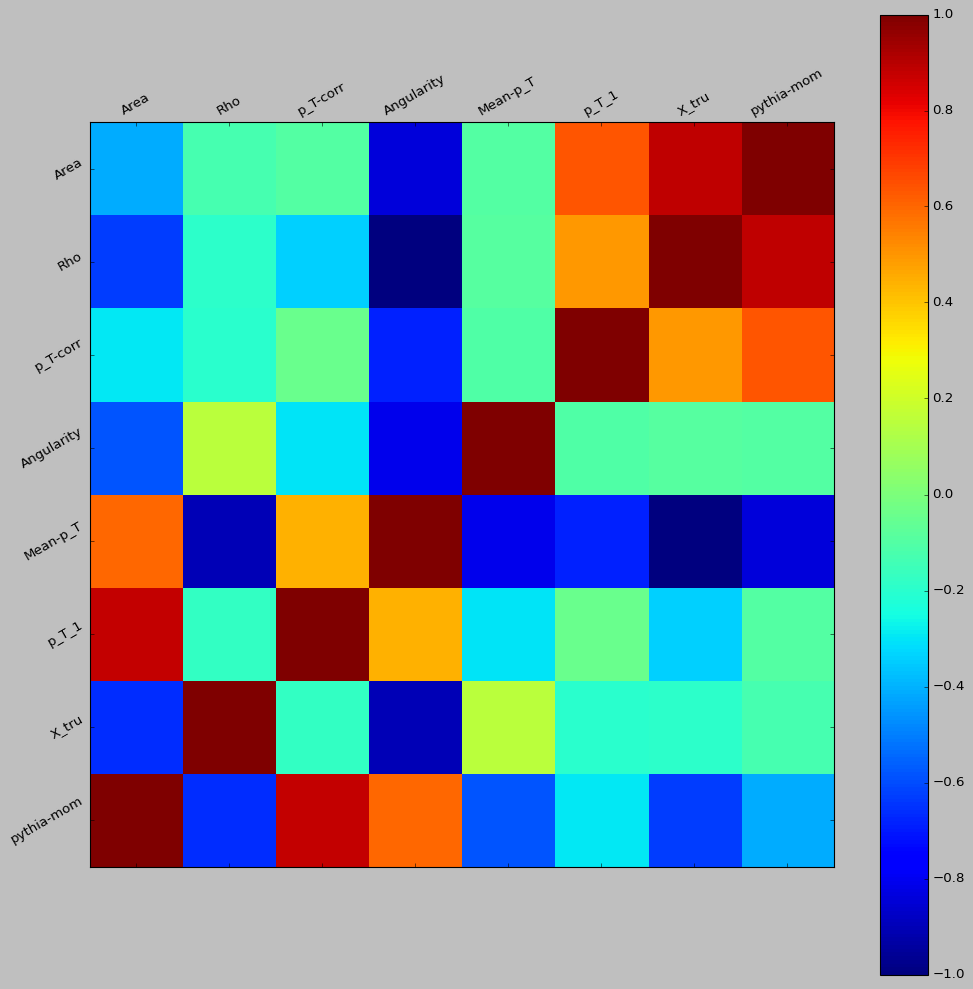

In [6]:
from matplotlib import cm, colors
plt.style.use("classic")
def plot_corr_mat(train):
    fig,ax = plt.subplots(1,figsize=(15,15))
    ax.matshow(train.corr())
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=-1, vmax=1)), ax=ax)
    cols = train.columns
    plt.xticks(np.linspace(0, len(cols)-2, len(cols)-1), cols.drop('Label'), rotation=30)
    plt.yticks(np.linspace(len(cols)-2, 0, len(cols)-1), cols.drop('Label'), rotation=30)
    plt.ylim(-0.5, len(cols)-2+0.5)
    plt.xlim(-0.5, len(cols)-2+0.5)
plot_corr_mat(train)

Create a Decision Tree Classifier [See here](https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248 ). It then fits the features, X, to the labels, Y.


In [7]:
clf = DecisionTreeClassifier()
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Now, let's print the feature importance for the simple Decision Tree. I-Spy: We want to look for features that we might expect to be important and those that surprise us. We also want to be wary of variables like Eta and Phi that should have no importance whatsoever according to the physics. High feature importances for these variables indicate an overfitting problem: it's learning the quirks of Pythia moreso than it generalizes to basic physics. We will see that this serves as a good comparison to the Random Forest Classifier since that is a forest of decision trees. A random forest will be less susceptible to overfitting.

In [8]:
print(X.columns)
clf.feature_importances_
i=0
for col in X.columns:
    print("%s: %f"%(col, clf.feature_importances_[i]))
    i+=1

Index(['Area', 'Rho', 'p_T-corr', 'Angularity', 'Mean-p_T', 'p_T_1'], dtype='object')
Area: 0.171309
Rho: 0.141843
p_T-corr: 0.143515
Angularity: 0.133461
Mean-p_T: 0.134323
p_T_1: 0.275547


Now we make the Random Forest Classifier and we specify some hyperparameters(parameters that arre not learned during the fitting process). The max_depth controls how specific we can get with our questions. Think the 20 questions effect: with 20 questions you can guess anything. By limiting the depth we intentionally ignore less important information in favor of the most efficient feature decisions. The criterion ["entropy'|'gini'] determines the optimization factor. I would like to implement a custom metric that accounts for efficiency of true jets. random_state is just a seed.

In [9]:
import itertools
clf = RandomForestClassifier(oob_score=True, random_state=42, 
n_jobs=-1)
best_params = {}
cv_results = {}

n_est_s = (100,200) # Number of Estimators in the forest

crit_s = ('gini', 'entropy') # Criterion for evaluating purity

max_depth = (1, 2,3, 4, 5, 6) # Number of decision layers available to the decision trees

min_samples_split = (2, 4, 20, 40, 100) # Minimum number of samples required to split an internal node

min_samples_leaf = (100, 1000, 2000) # Minimum number of samples allowed left after a split

min_weight_fraction_leaf = (0.1, 0.2, 0.3, 0.45) # ??

max_features = (1,2,3,4, 5, 6)

max_leaf_nodes = (10, 100, 1000)

min_impurity_decrease = (0.0, 0.3, 0.8)

class_weight = ({0:1, 1:1, 2:10}, {0:1,1:1,2:100}, {0:1, 1:1, 2:1000})

max_samples = (0.0, 0.2, 0.4, 0.8, 1.0)

names=np.array(['n_estimators', 'criterion', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'class_weight', 'max_samples'])

all_combinations = []
all_combinations.append(n_est_s)
all_combinations.append(crit_s)
all_combinations.append(max_depth)
all_combinations.append(min_samples_leaf)
all_combinations.append(min_samples_split)
all_combinations.append(min_weight_fraction_leaf)
all_combinations.append(max_features)
all_combinations.append(max_leaf_nodes)
all_combinations.append(min_impurity_decrease)
all_combinations.append(class_weight)
all_combinations.append(max_samples)

print(len(all_combinations))
for name, feat in zip(names,all_combinations):
    params = {name:feat}
    print(params)
    gcv = GridSearchCV(clf, params)
    gcv.fit(X,Y)
    print(gcv.best_params_)
    print(gcv.cv_results_)
    best_params[name]=gcv.best_params_[name]
    cv_results[name]=gcv.cv_results_


11
{'n_estimators': (100, 200)}


KeyboardInterrupt: 

In [15]:
print("Best parameters", best_params, "\n\nCV_Results", cv_results)

Best parameters {'n_estimators': {'n_estimators': 200}} 

CV_Results {'n_estimators': {'mean_fit_time': array([4.75941261, 5.26017475]), 'std_fit_time': array([0.23283081, 0.16821147]), 'mean_score_time': array([0.14379938, 0.21057423]), 'std_score_time': array([0.05132046, 0.00127836]), 'param_n_estimators': masked_array(data=[100, 200],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 100}, {'n_estimators': 200}], 'split0_test_score': array([0.69427245, 0.69620743]), 'split1_test_score': array([0.69647696, 0.70228417]), 'split2_test_score': array([0.68810539, 0.6923673 ]), 'mean_test_score': array([0.69295302, 0.69695405]), 'std_test_score': array([0.00354241, 0.00408233]), 'rank_test_score': array([2, 1], dtype=int32)}}


# Best Parameters

max_features: 1


min_impurity_decrease: 0.0


criterion: entropy


class_weight: {0: 1, 1: 1, 2: 100}


max_leaf_nodes: 10


min_weight_fraction_leaf: 0.0


min_samples_leaf: 100


min_samples_split: 100


max_depth: 5




In [10]:
clf = RandomForestClassifier(oob_score=True, random_state=42, 
n_jobs=-1, max_features=1, criterion='gini', class_weight={0:1,1:1,2:100}, max_leaf_nodes=10, min_weight_fraction_leaf=0.0, min_samples_leaf=100, min_samples_split=100, max_depth=2)
clf.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1, 2: 100},
                       criterion='gini', max_depth=2, max_features=1,
                       max_leaf_nodes=10, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=100,
                       min_samples_split=100, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=True,
                       random_state=42, verbose=0, warm_start=False)

Feature importances for the random forest. We see that when we have more perspectives(100 decision trees) we squash unimportant variables like Eta, Phi, and p_T-corr.

In [11]:
i=0
for col in X.columns:
    print(col, clf.estimators_[5].feature_importances_[i])
    i+=1

Area 0.0
Rho 0.690662815376563
p_T-corr 0.30933718462343696
Angularity 0.0
Mean-p_T 0.0
p_T_1 0.0


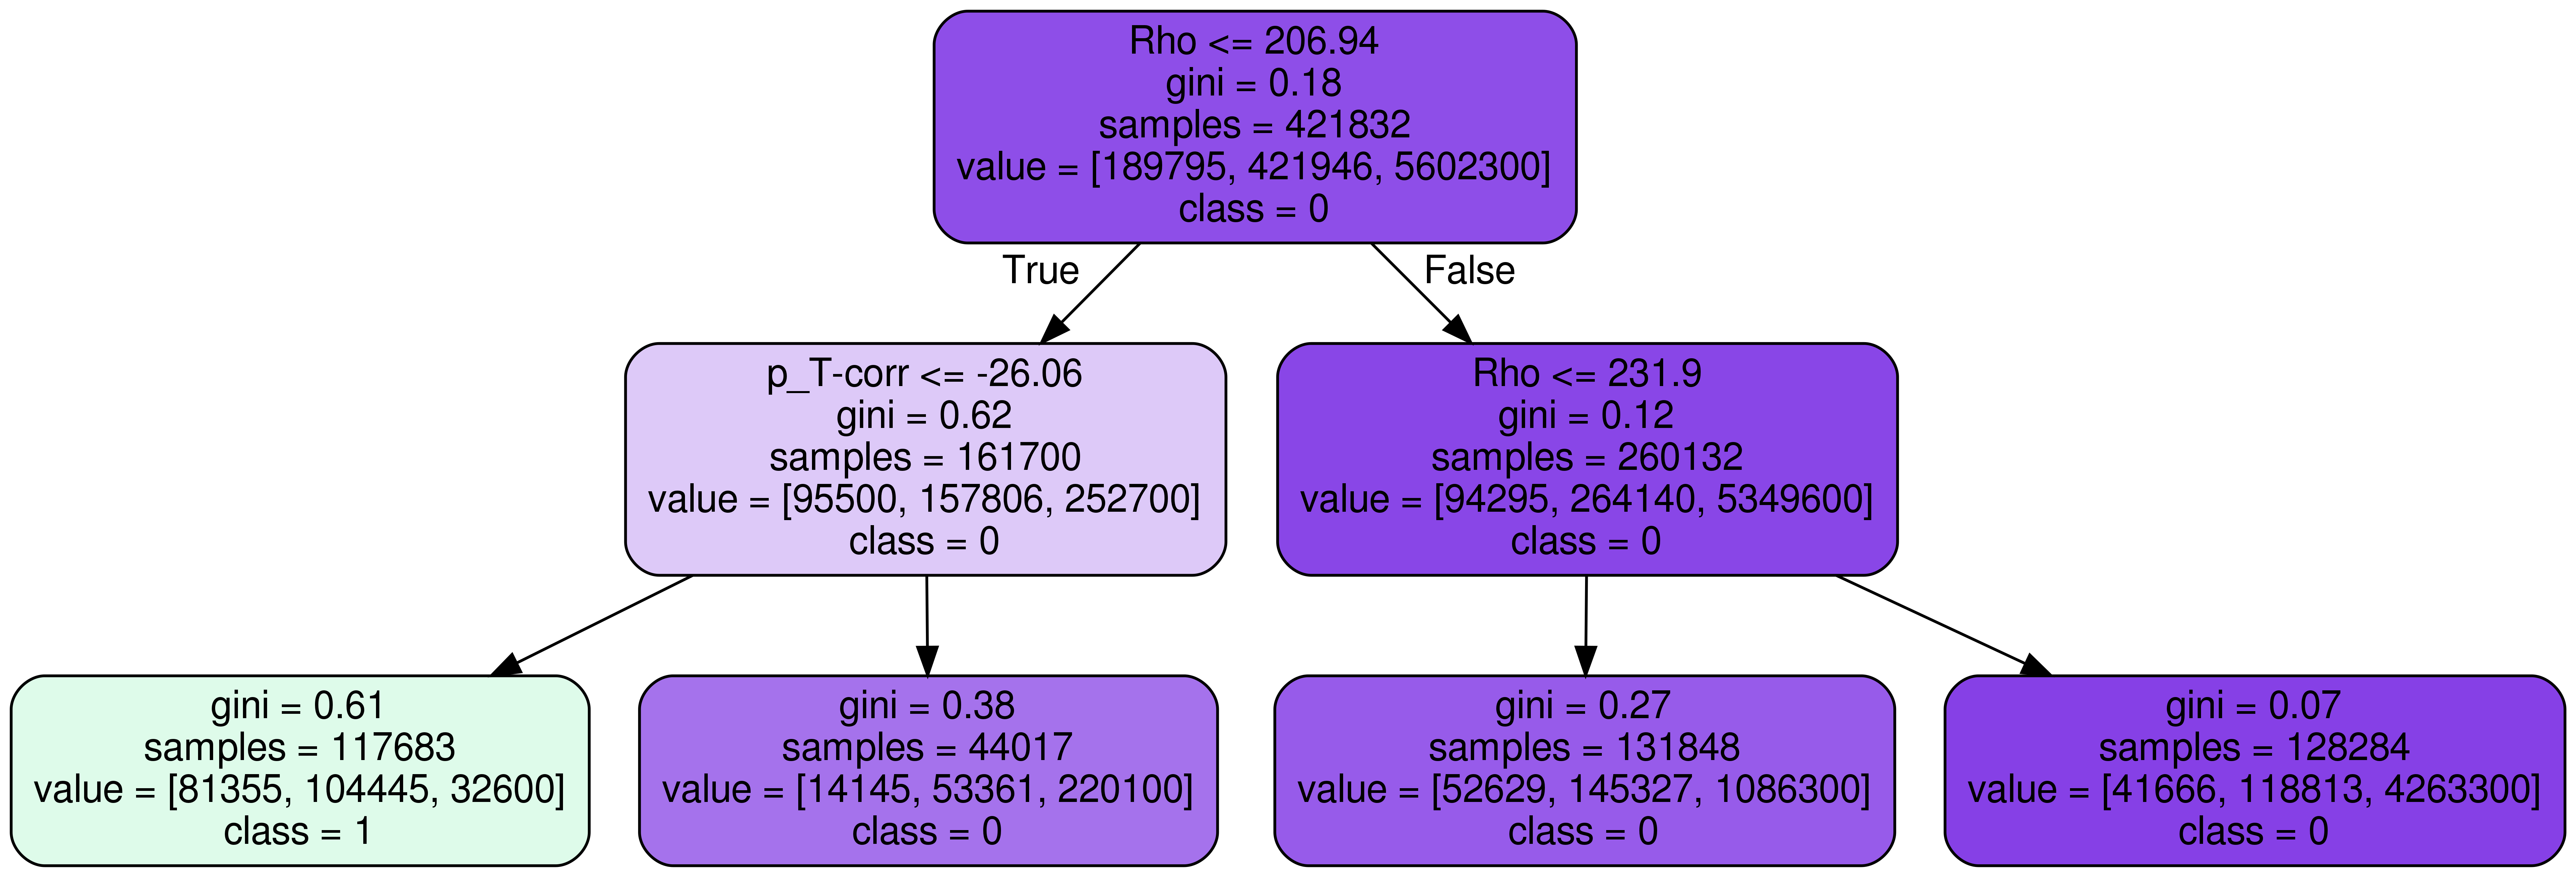

In [12]:

#print(gcv.best_estimator_.get_params())
# Extract single tree
estimator = clf.estimators_[5]
#estimator.fit(X, Y)

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = list(map(lambda x:str(x), dat_drop['Label'].unique())),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


Here we plot the decision tree structure of one of the trees. It shows us the cuts made and the impurity/entropy/efficiency.

In [33]:
n_classes=2

plot_colors = "rb"
marker_style = "+x"
plot_step = 0.05

ar = np.array([np.ones(len(X.columns))*k for k in range(len(X.columns))], dtype=int)
subar = np.tile(range(len(X.columns)), len(X.columns))
enar = list(map(lambda x: list(x),zip(ar.ravel(), subar)))
print(enar)

f = plt.figure(figsize=(30,30))

for pairidx, pair in enumerate(enar):
    # We only take the two corresponding features
    print(pair)
    X_ = X.iloc[:,pair]
    y = Y

    # Train
    #clf = RandomForestClassifier(max_depth=3, criterion='gini',class_weight={0:1, 1:10}, random_state=42)
    clf.fit(X_,y)
    # Plot the decision boundary
    plt.subplot(len(X.columns), len(X.columns), pairidx + 1)
    print(pair[0])
    x_min, x_max = X_.iloc[:,0].min() - 1, X_.iloc[:,0].max() + 1
    y_min, y_max = X_.iloc[:,1].min() - 1, X_.iloc[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.xlabel(X.columns[pair[0]])
    plt.ylabel(X.columns[pair[1]])
    for i, color, mark in zip(range(n_classes), plot_colors, marker_style):
        idx = np.where(y == i)
        plt.scatter(X_.iloc[idx].iloc[:,0], X_.iloc[idx].iloc[:,1],alpha=0.5, c=color, marker=mark,label=y.unique()[i], cmap=plt.cm.RdYlBu, s=5)

    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)

    

    # Plot the training points
    

print("Done")
plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight")
plt.savefig("DecBound.png")


[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5]]
[0, 0]
0
[0, 1]
0
[0, 2]
0
[0, 3]
0
[0, 4]
0
[0, 5]
0
[1, 0]
1
[1, 1]
1


MemoryError: Unable to allocate 2.69 GiB for an array with shape (18986, 18986) and data type float64

In [30]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,n_iter=250 ,random_state=0)



In [31]:
feat_name = 'Rho'
cut = 250
X_2d = tsne.fit_transform(X.loc[X[feat_name]>=cut])
print(X_2d.shape)

KeyboardInterrupt: 

In [ ]:
target_ids = [0,1,2]

plt.figure(figsize=(15, 15))
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, [0,1,2]):
    print(i)
    plt.scatter(X_2d[Y.loc[X[feat_name]>=cut] == i, 0], X_2d[Y.loc[X[feat_name]>=cut] == i, 1], alpha=0.5, c=c, label=label)
plt.legend()
plt.show()